In [14]:
import os
import sys
from importlib import reload
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
        
from time import time 
import csv

import numpy as np
import pandas as pd

import gb1
import utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('white')

MODEL_PATH = '/data/wongfanc/gb1-models/'

# load results and plot

In [15]:
# load design distributions from both imputation and PP
temperatures = np.arange(0.2, 0.701, 0.005)
imptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
imptemp2mean = gb1.get_true_mean_label_from_theta(imptemp2theta)

pptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
pptemp2mean = gb1.get_true_mean_label_from_theta(pptemp2theta) 

In [16]:
# load PP selection results, computed in gb1-022823 nb
reload(utils)
target_values = np.arange(0.0, 1.51, 0.05)
n_pp_trial = 500
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-ncal5000-042924.csv'

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, pptemp2mean, n_pp_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 31 target values in [0.00, 1.50], 500 trials, and alpha = 0.1
Done processing (35 s)


In [17]:
# load imputation selection results, computed in gb1-imputation-051324.ipynb
reload(utils)
n_imp_trial = 10

imp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-091824.csv'
imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, imptemp2mean, n_imp_trial, imp_or_pp='imp'
)


Processing imp results with 101 temperatures in [0.200, 0.700], 31 target values in [0.00, 1.50], 10 trials, and alpha = 0.1
Done processing (0 s)


In [18]:
# load wheelock results
reload(utils)
wf_csv_fname = '/data/wongfanc/gb1-results/gb1-wf-120324.csv'
qs = [0, 0.6, 1]
temp_names = ['temp{:.4f}'.format(round(temp, 4)) for temp in temperatures]
imp_name2truemeans = {
    'temp{:.4f}'.format(round(temp, 4)): imptemp2mean[round(temp, 4)]
    for temp in temperatures
}

wf_df = pd.read_csv(wf_csv_fname, index_col=0)
wf_type2results = utils.process_wheelock_selection_experiments(
    wf_df, target_values, temp_names, imp_name2truemeans, n_imp_trial, qs=qs
)

In [19]:
# load CP results, computed in gb1-cp-110724.ipynb
cp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-cp-110724.csv'
cp_df = pd.read_csv(cp_results_csv_fname, index_col=0)

In [20]:
reload(utils)
cpworst_v, cperr_v, cpdisc_v = utils.process_cp_selection_experiments(
    cp_df, target_values, temperatures, pptemp2mean, 100
)

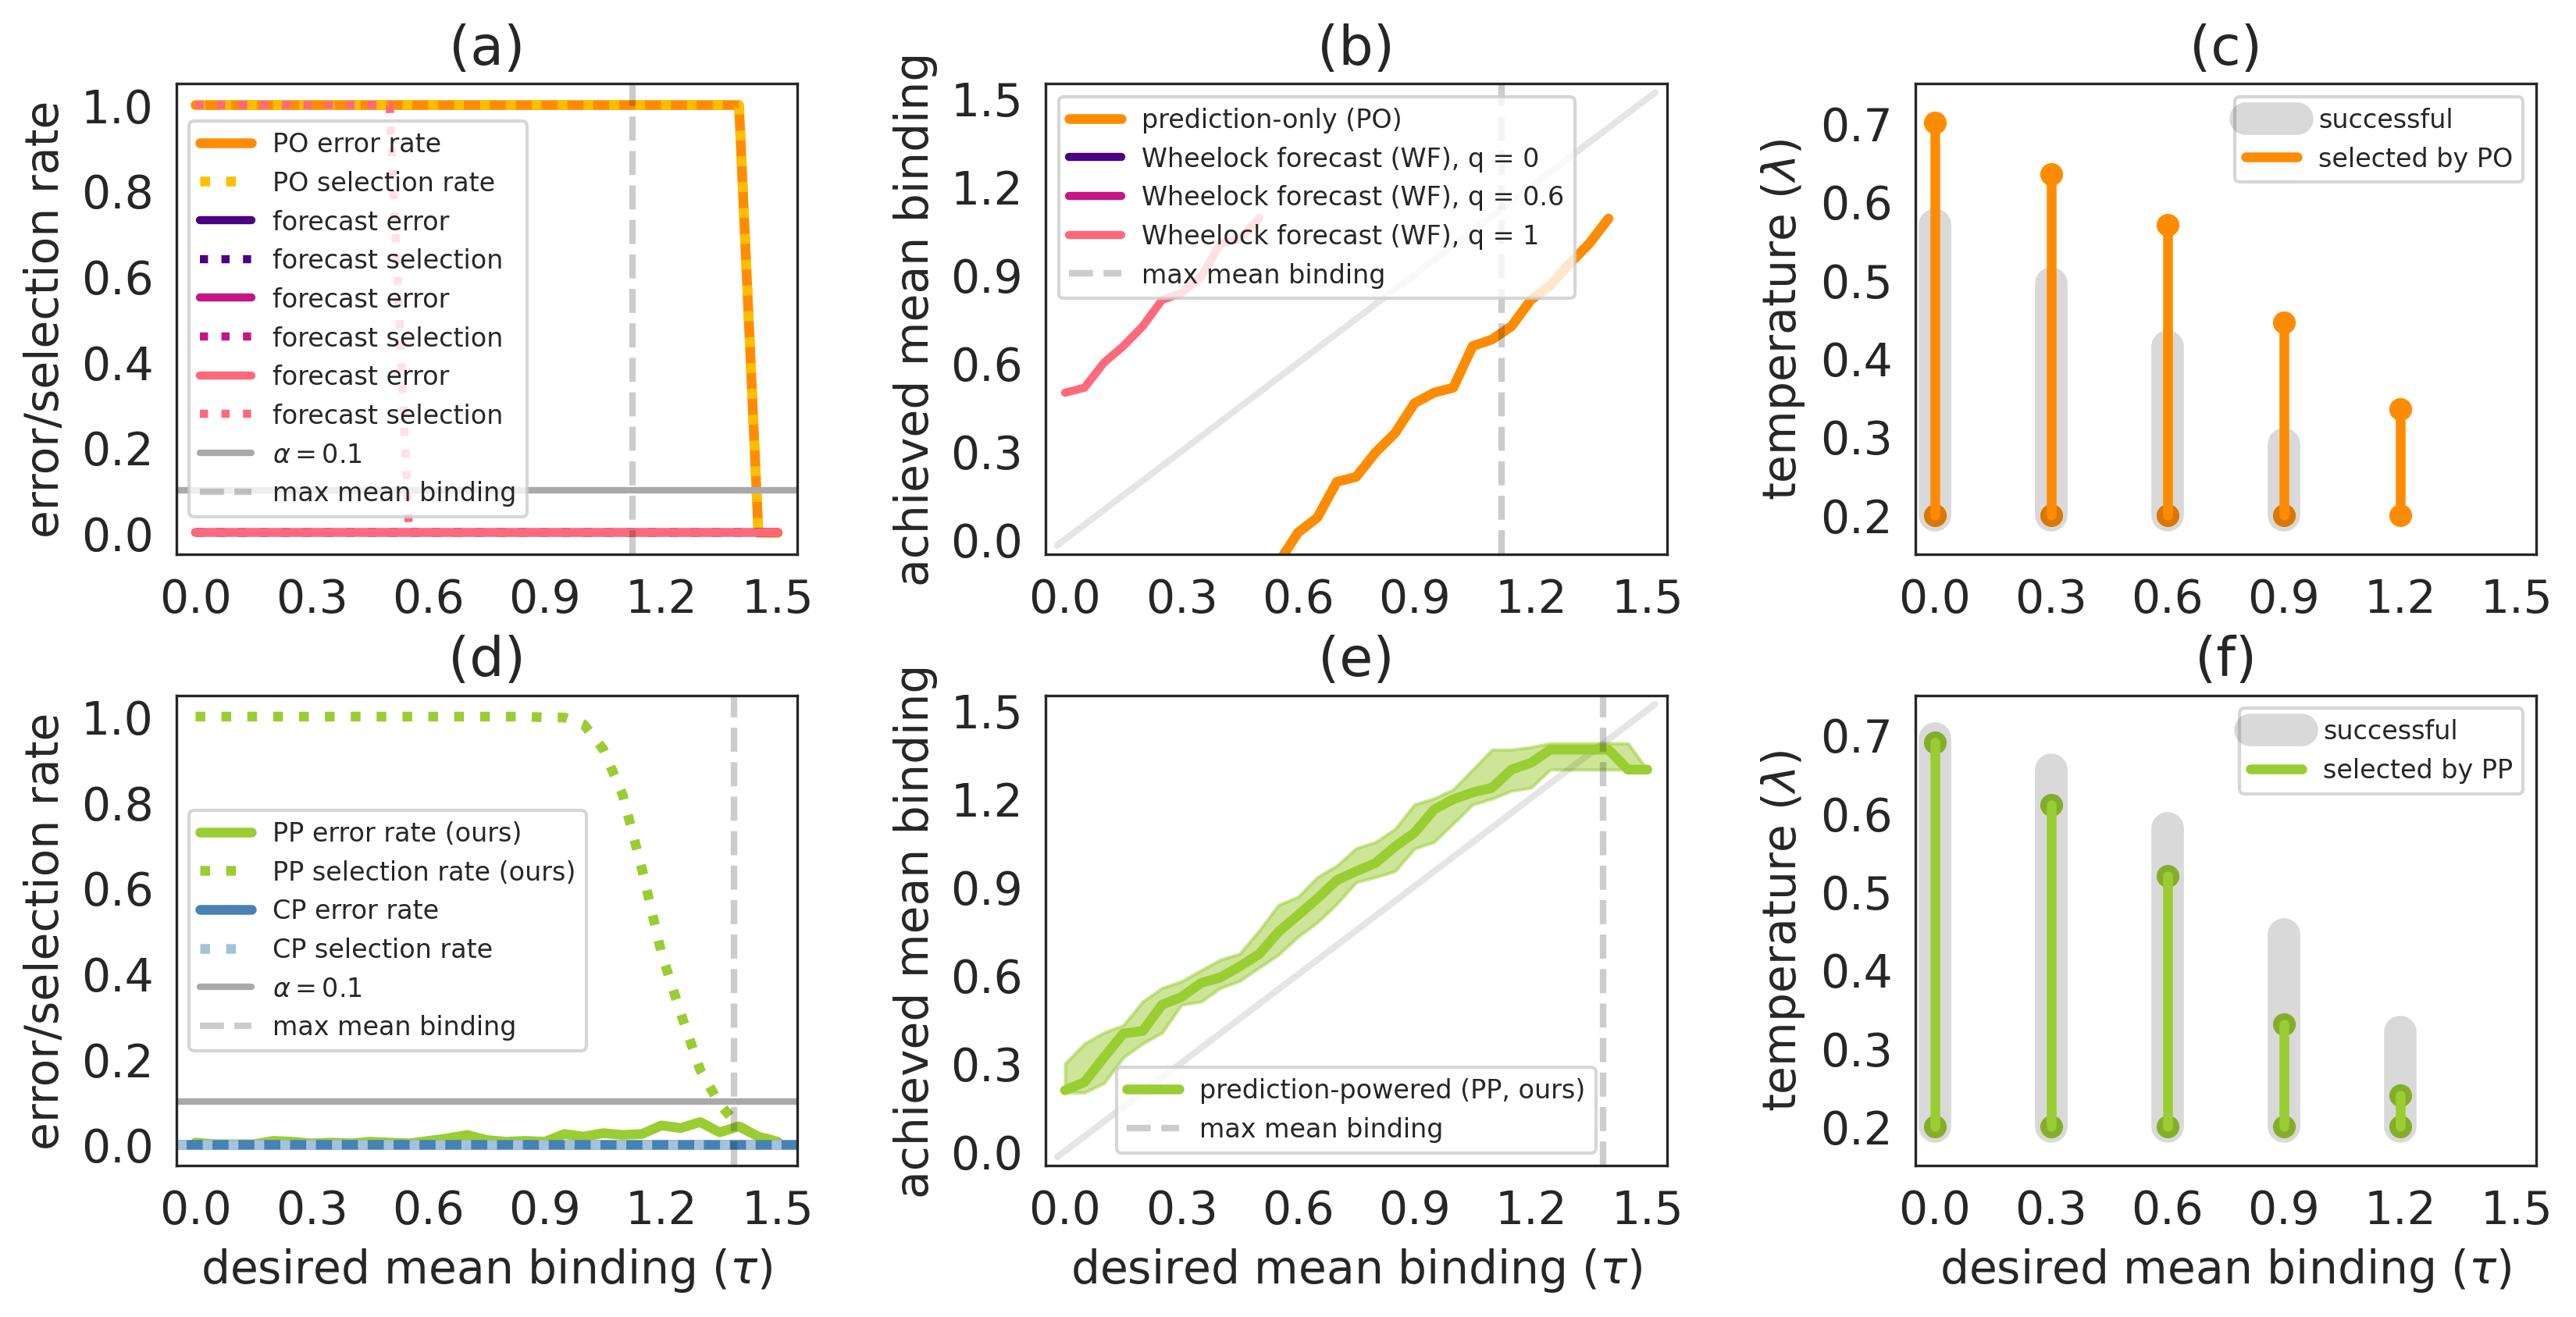

In [21]:
# plot two-row figure
fig, axs = plt.subplots(2, 3, figsize=(13, 6), dpi=300)
ax00 = axs[0, 0]
ax10 = axs[1, 0]
ax01 = axs[0, 1]
ax11 = axs[1, 1]
ax02 = axs[0, 2]
ax12 = axs[1, 2]
fig.subplots_adjust(wspace=0.4, hspace=0.3)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'
lw = 2.5  # TODO: use throughout
imp_xlim = [-0.05, 1.55]
imp_xticks = np.arange(0, 1.55, 0.3)
pp_xlim = [-0.05, 1.55]
pp_xticks = np.arange(0, 1.55, 0.3)


imp_max_achievable = np.max(list(imptemp2mean.values()))
pp_max_achievable = np.max(list(pptemp2mean.values()))

# ===== subplots (a, d) =====

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=3, label='PO error rate');
ax00.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO selection rate');
for q_idx, q in enumerate(qs):
    _, wferr_v, wfdisc_v, _ = wf_type2results['cs'][q]
    ax00.plot(target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw, label='forecast error');
    ax00.plot(target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw, label='forecast selection');
    
ax00.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax00.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax00.legend(fontsize=8)
ax00.set_ylabel('error/selection rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.05, 0.2))
ax00.set_xlim(imp_xlim)
ax00.set_xticks(imp_xticks)
ax00.set_title('(a)')

ax10.plot(target_values, pperr_v, c=pp_color, linewidth=3, label='PP error rate (ours)');
ax10.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP selection rate (ours)');
# ax10.plot(target_values, cperr_v, c='steelblue', linewidth=3, label='CP error rate');
# ax10.plot(target_values, cpdisc_v, ':', c='steelblue', linewidth=3, label='CP selection rate');
ax10.axhline(0, color='steelblue', linewidth=3, label='CP error rate');
ax10.axhline(0, color=(164/255, 195/255, 218/255), linestyle=':', linewidth=3, label='CP selection rate');
ax10.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax10.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax10.legend(fontsize=8)
ax10.set_ylabel('error/selection rate');
ax10.set_xlabel(r'desired mean binding ($\tau$)');
ax10.set_ylim([-0.05, 1.05])
ax10.set_yticks(np.arange(0, 1.05, 0.2))
ax10.set_xticks(pp_xticks)
ax10.set_xlim(pp_xlim)
ax10.set_title('(d)')


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
ax01.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    wfworst_v, _, _, _ = wf_type2results['cs'][q]
    ax01.plot(
        target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
        c=wf_colors[q_idx], label=f'Wheelock forecast (WF), q = {q}', linewidth=lw,
    )
    ax01.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
        color=wf_colors[q_idx], alpha=0.5,
    )
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)
ax01.set_title('(b)')

ax11.plot([np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          '-k', alpha=0.1, linewidth=2)
ax11.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
)
ax11.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
# ax11.plot(
#     target_values, [np.median(worst) if len(worst) else np.nan for worst in cpworst_v],
#     c='steelblue', label='CP, no Bonferroni', linewidth=3,
# )
# ax11.fill_between(
#     target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in cpworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in cpworst_v],
#     color='steelblue', alpha=0.5,
# )
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax11.legend(fontsize=8)
ax11.set_xlabel(r'desired mean binding ($\tau$)');
ax11.set_ylabel('achieved mean binding');
ax11.set_xlim(pp_xlim)
ax11.set_ylim(pp_xlim)
ax11.set_xticks(pp_xticks)
ax11.set_yticks(pp_xticks)
ax11.set_title('(e)')


# ===== subplots (c, f) =====

trial_idx = 1 # 100 # 25, 451 
example_targets = [0, 0.3, 0.6, 0.9, 1.2, 1.5]

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    imptruetemps = [t for t in temperatures if imptemp2mean[round(t, 4)] >= val]
    if len(imptruetemps):
        ax02.plot([val, val], [np.min(imptruetemps), np.max(imptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='successful' if v == 0 else None)
    
    # plot temperature selected by imputation, if any
    if val in impval2temprange and len(impval2temprange[val][trial_idx]):
        ax02.plot([val, val], impval2temprange[val][trial_idx],
                       linewidth=3, c=imp_color, label='selected by PO' if v == 0 else None)
        ax02.scatter(
            [val, val], impval2temprange[val][trial_idx],
            marker='o', c=imp_color
        )
        
ax02.legend(fontsize=8)
ax02.set_ylim([0.15, 0.75])
ax02.set_ylabel(r'temperature ($\lambda$)');
ax02.set_xticks(example_targets)
ax02.set_yticks(np.arange(0.2, 0.71, 0.1))
ax02.set_xlim([-0.05, 1.55])
ax02.set_title('(c)')

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    pptruetemps = [t for t in temperatures if pptemp2mean[round(t, 4)] >= val]
    if len(pptruetemps):
        ax12.plot([val, val], [np.min(pptruetemps), np.max(pptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='successful' if v == 0 else None)
    
    # plot temperature selected by PP, if any
    if val in ppval2temprange and len(ppval2temprange[val][trial_idx]):
        ax12.plot([val, val], ppval2temprange[val][trial_idx],
                       linewidth=3, c=pp_color, label='selected by PP' if v == 0 else None)
        ax12.scatter([val, val], ppval2temprange[val][trial_idx],
                          marker='o', c=pp_color)
        
ax12.legend(fontsize=8)
ax12.set_ylim([0.15, 0.75])
ax12.set_ylabel(r'temperature ($\lambda$)');
ax12.set_xlabel(r'desired mean binding ($\tau$)');
ax12.set_xticks(example_targets)
ax12.set_yticks(np.arange(0.2, 0.71, 0.1))
ax12.set_xlim([-0.05, 1.55]);
ax12.set_title('(f)');

# plt.savefig('../figures/gb1-.png')


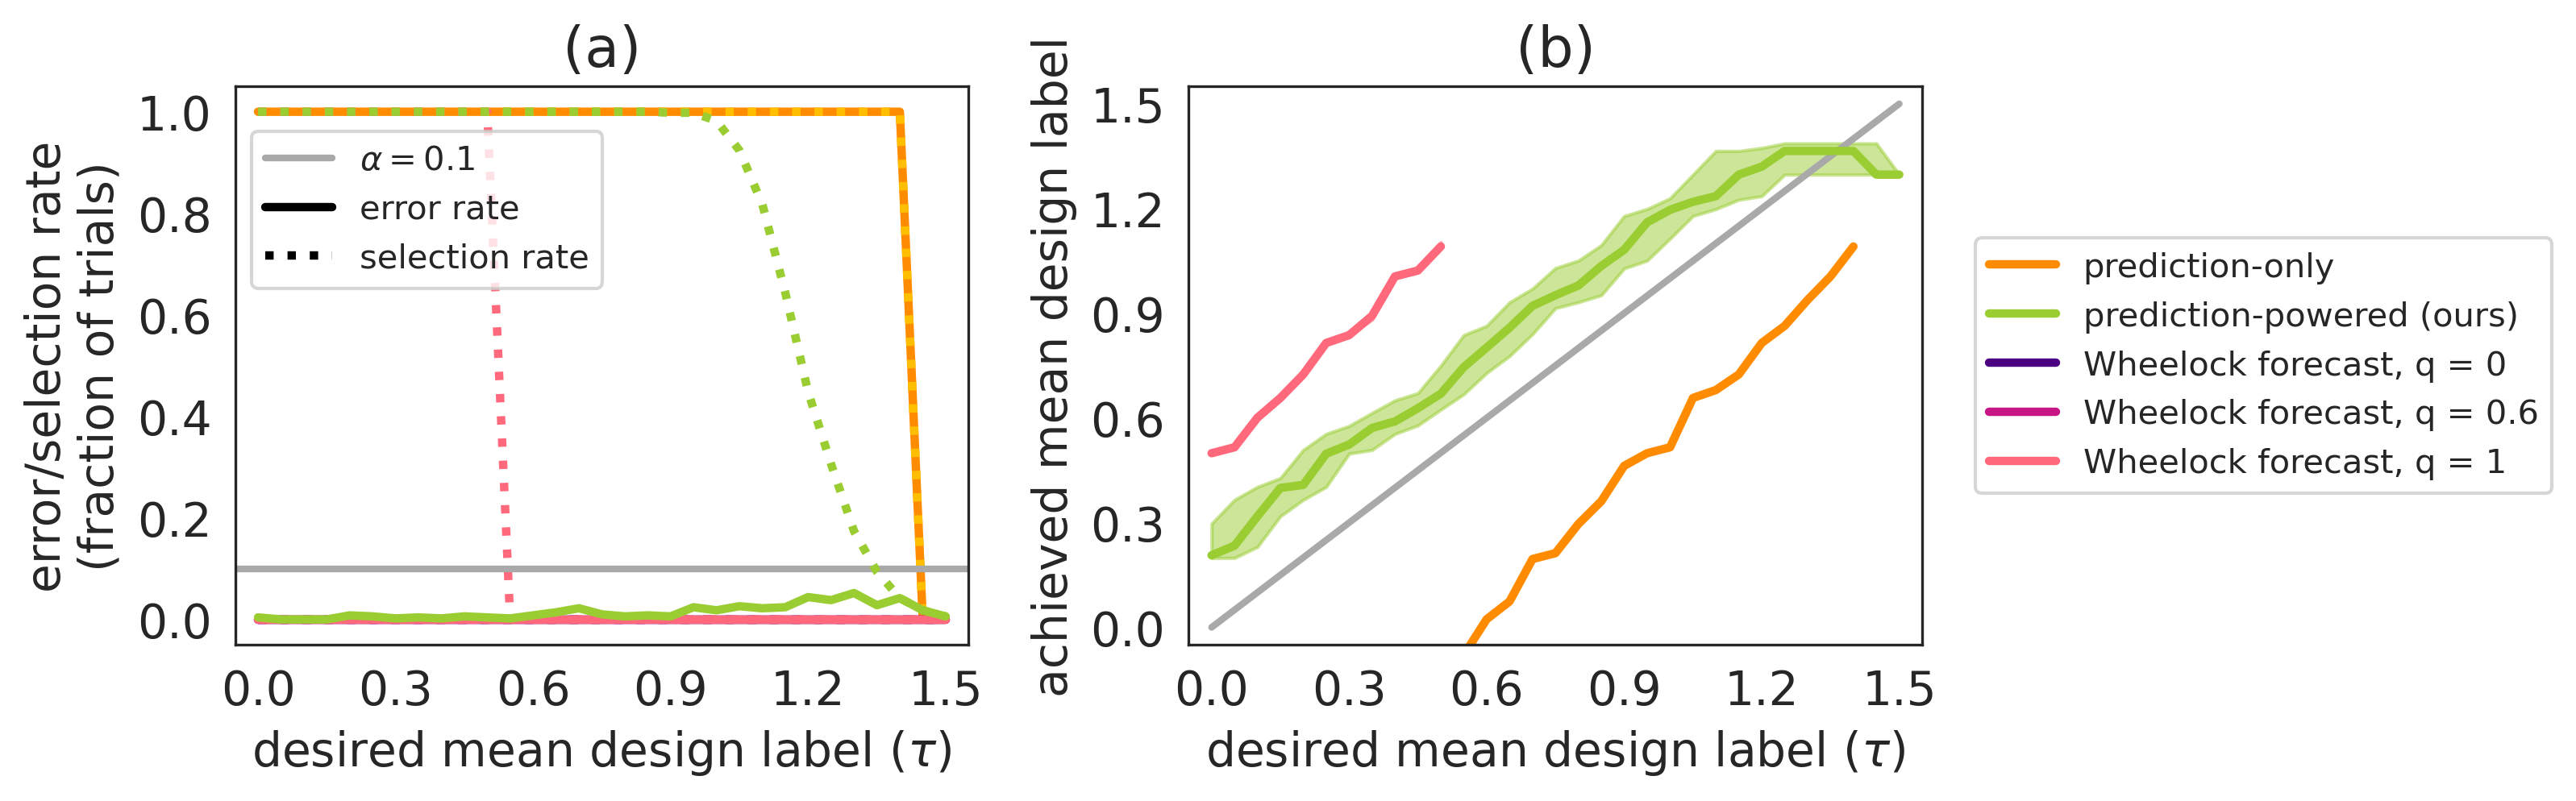

In [56]:
# one-row figure
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax0 = axs[0]
ax1 = axs[1]
fig.subplots_adjust(wspace=0.3)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'darkgray'

lw = 2.5
legend_fs = 10
imp_xlim = [-0.05, 1.55]
imp_xticks = np.arange(0, 1.55, 0.3)
pp_xlim = [-0.05, 1.55]
pp_xticks = np.arange(0, 1.55, 0.3)

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====
ax0.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
ax0.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw);

for q_idx, q in enumerate(qs):
    _, wferr_v, wfdisc_v, _ = wf_type2results['cs'][q]
    ax0.plot(target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw);
    ax0.plot(target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw);
    
ax0.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));

ax0.plot(target_values, pperr_v, c=pp_color, linewidth=lw);
ax0.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=lw);

# ax0.plot(target_values, cperr_v, c='steelblue', linewidth=lw);
# ax0.plot(target_values, cpdisc_v, ':', c='steelblue', linewidth=lw);

# dummy so get legend labels
ax0.plot(-1, -1, linestyle='-', color='k', linewidth=lw, label='error rate')
ax0.plot(-1, -1, linestyle=':', color='k', linewidth=lw, label='selection rate')

ax0.set_ylim([-0.05, 1.05])
ax0.set_yticks(np.arange(0, 1.05, 0.2))
ax0.set_xlim(imp_xlim)
ax0.set_xticks(imp_xticks)
ax0.set_ylabel('error/selection rate\n(fraction of trials)');
ax0.set_xlabel(r'desired mean design label ($\tau$)');
ax0.set_title('(a)')
ax0.legend(fontsize=legend_fs, loc='upper left', bbox_to_anchor=(0.0, 0.95))


# ===== subplot (b) =====

ax1.plot([0, 1.5], [0, 1.5], '-', c=dark_line_color, alpha=1, linewidth=2);
ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    wfworst_v, _, _, _ = wf_type2results['cs'][q]
    ax1.plot(
        target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
        c=wf_colors[q_idx], label=f'Wheelock forecast, q = {q}', linewidth=lw,
    )
    ax1.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
        color=wf_colors[q_idx], alpha=0.5,
    )

    
# ax1.plot(
#     target_values, [np.median(worst) if len(worst) else np.nan for worst in cpworst_v],
#     c='steelblue', label='conformal prediction-based', linewidth=lw,
# )
# ax1.fill_between(
#     target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in cpworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in cpworst_v],
#     color='steelblue', alpha=0.5,
# )

ax1.set_xlim(imp_xlim)
ax1.set_ylim(imp_xlim)
ax1.set_xticks(imp_xticks)
ax1.set_yticks(imp_xticks)
ax1.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');


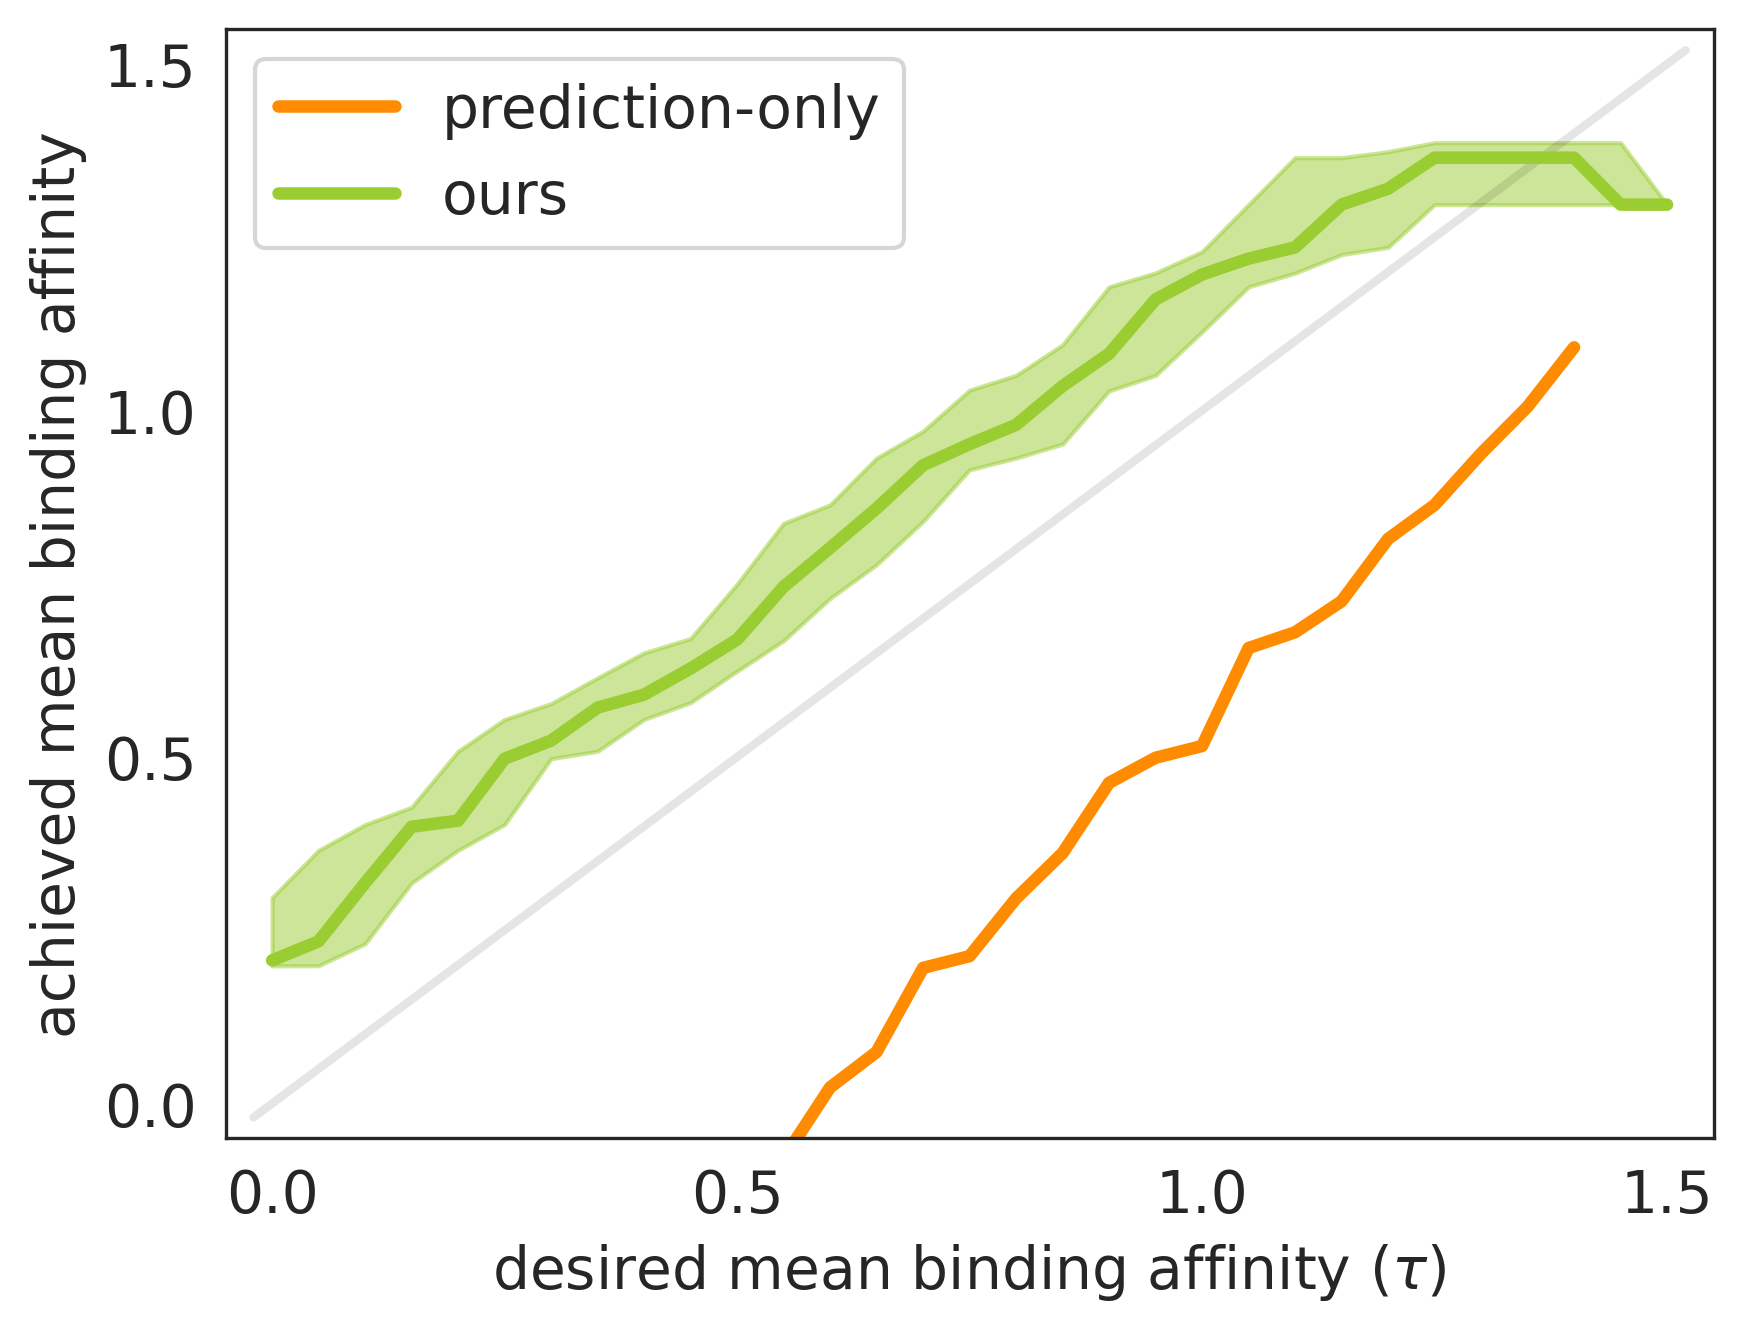

In [23]:
# demo figure for talks
sns.set_style('white')
alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
imp_xlim = [-0.05, 1.55]
imp_xticks = np.arange(0, 1.55, 0.5)
pp_xlim = [-0.05, 1.55]
pp_xticks = np.arange(0, 1.55, 0.5)

q_low = 0.2
q_high = 0.8

plt.figure(dpi=300)
plt.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
plt.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only', linewidth=3,
)
plt.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
plt.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='ours', linewidth=3,
)
plt.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

plt.ylabel('achieved mean binding affinity');
plt.xlabel(r'desired mean binding affinity ($\tau$)');
plt.xlim(imp_xlim);
plt.ylim(imp_xlim);
plt.xticks(imp_xticks);
plt.yticks(imp_xticks);
plt.legend();

## exceedance

In [28]:
imptemp2exceed = gb1.get_true_mean_label_from_theta(imptemp2theta, threshold=1.1)
pptemp2exceed = gb1.get_true_mean_label_from_theta(pptemp2theta, threshold=1.1) 

In [34]:
# load PP selection results, computed in gb1-022823 nb
reload(utils)
target_values = np.arange(0.0, 1., 0.02)
n_pp_trial = 500
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-ncal8000_exceed1.1-tr3000_091924.csv'

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, pptemp2exceed, n_pp_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 50 target values in [0.00, 0.98], 500 trials, and alpha = 0.1
Done processing (59 s)


In [94]:
# load imputation selection results, computed in gb1-imputation nb
target_values = np.arange(0.0, 1., 0.02)
n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-exceed1.1-092024.csv'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, imptemp2exceed, n_imp_trial, imp_or_pp='imp'
)

Processing imp results with 101 temperatures in [0.200, 0.700], 50 target values in [0.00, 0.98], 10 trials, and alpha = 0.1
Done processing (1 s)


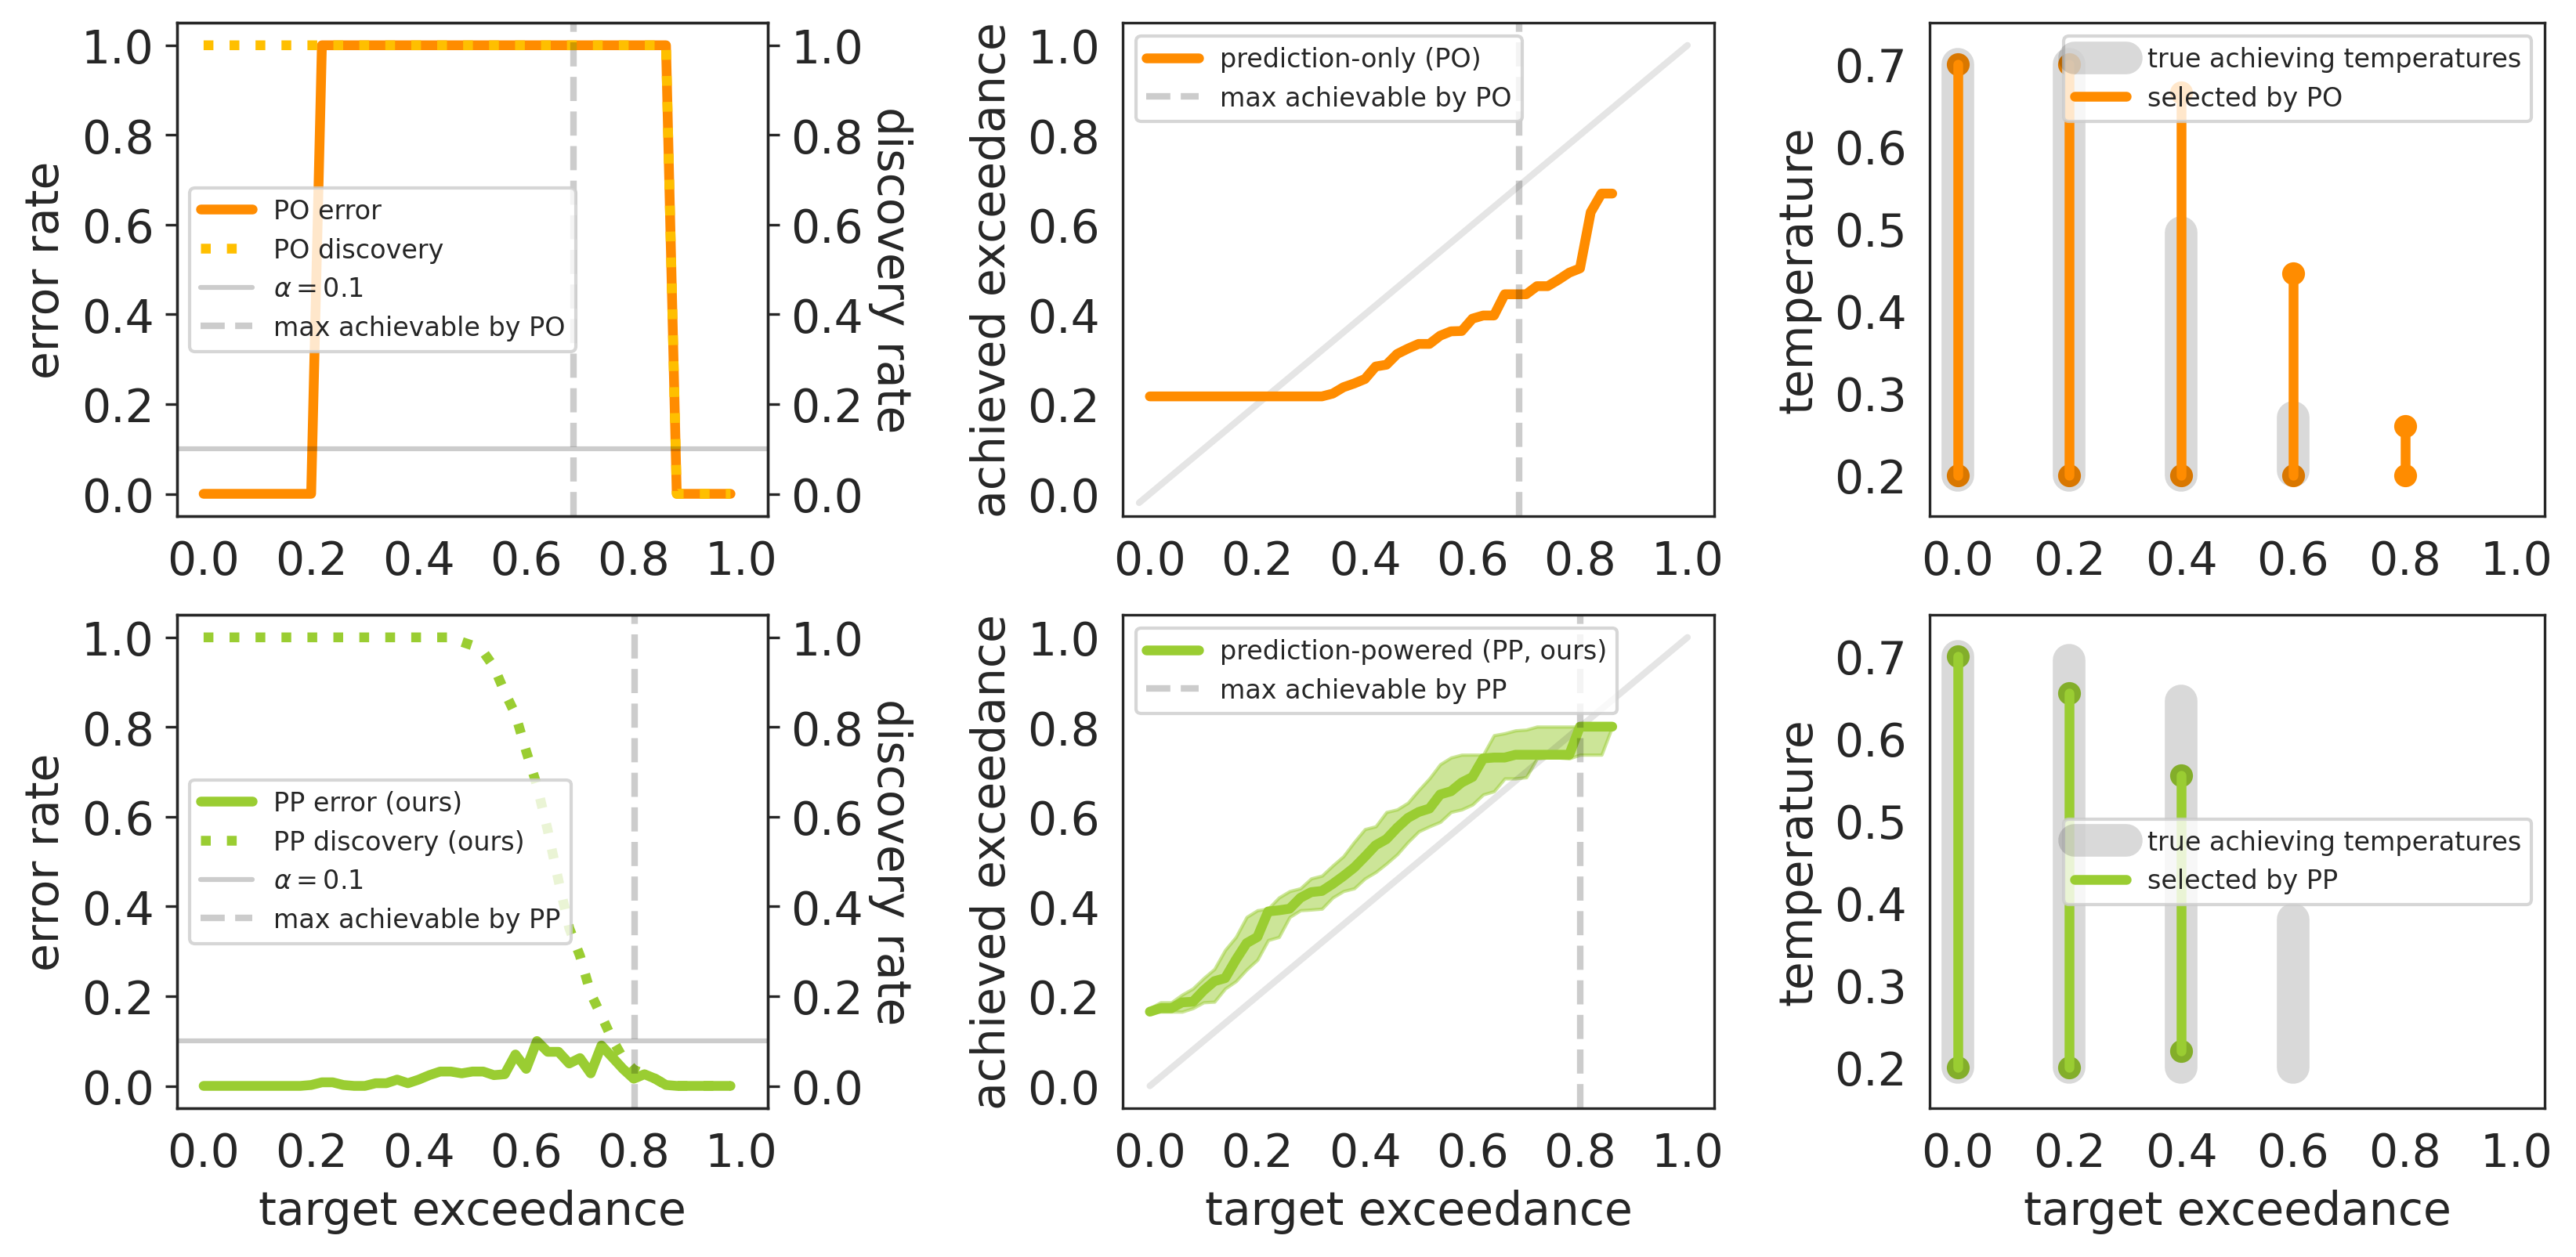

In [106]:
# plot two-row figure
fig = plt.figure(figsize=(13, 6), dpi=300)
outer = gridspec.GridSpec(1, 2, width_ratios = [2.5, 1], wspace=0.2)
gsleft = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outer[0], wspace=0.6)
gsright = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1])
ax00 = fig.add_subplot(gsleft[0, 0])
ax10 = fig.add_subplot(gsleft[1, 0])
ax01 = fig.add_subplot(gsleft[0, 1])
ax11 = fig.add_subplot(gsleft[1, 1])
ax02 = fig.add_subplot(gsright[0, 0])
ax12 = fig.add_subplot(gsright[1, 0])

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'

imp_max_achievable = np.max(list(imptemp2exceed.values()))
pp_max_achievable = np.max(list(pptemp2exceed.values()))

# ===== subplots (a, d) =====

ax00.set_ylabel('error rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
ax00.set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = ax00.twinx()
disc_ax.plot(target_values, imperr_v, c=imp_color, linewidth=3, label='PO error');
disc_ax.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO discovery');
disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PO')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xlim([-0.05, 1.05])

ax10.set_ylabel('error rate');
ax10.set_xlabel('target exceedance');
ax10.set_ylim([-0.05, 1.05])
ax10.set_xticks(np.arange(0, 1.05, 0.2))
ax10.set_yticks(np.arange(0, 1.05, 0.2))

disc_ax = ax10.twinx()
disc_ax.plot(target_values, pperr_v, c=pp_color, linewidth=3, label='PP error (ours)');
disc_ax.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP discovery (ours)');
disc_ax.axhline(alpha, linestyle='-', color='k', alpha=0.2, linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max achievable by PP')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xticks(np.arange(0, 1.05, 0.2))
disc_ax.set_xlim([-0.05, 1.05])


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '-k', alpha=0.1, linewidth=2
);
ax01.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PO')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved exceedance');
ax01.set_xlim([-0.05, 1.05])
ax01.set_ylim([-0.05, 1.05])
ax01.set_xticks(np.arange(0, 1.05, 0.2))
ax01.set_yticks(np.arange(0, 1.05, 0.2))

ax11.plot([0, 1], [0, 1], '-k', alpha=0.1, linewidth=2)
ax11.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
)
ax11.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max achievable by PP')
ax11.legend(fontsize=8)
ax11.set_xlabel('target exceedance');
ax11.set_ylabel('achieved exceedance');
ax11.set_xlim([-0.05, 1.05])
ax11.set_ylim([-0.05, 1.05])
ax11.set_xticks(np.arange(0, 1.05, 0.2))
ax11.set_yticks(np.arange(0, 1.05, 0.2))


# ===== subplots (c, f) =====

trial_idx = 0 # 100 # 25, 451 
example_targets = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    imptruetemps = [t for t in temperatures if imptemp2exceed[round(t, 4)] >= val]
    if len(imptruetemps):
        ax02.plot([val, val], [np.min(imptruetemps), np.max(imptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='true achieving temperatures' if v == 0 else None)
    
    # plot temperature selected by imputation, if any
    if val in impval2temprange and len(impval2temprange[val][trial_idx]):
        ax02.plot([val, val], impval2temprange[val][trial_idx],
                       linewidth=3, c=imp_color, label='selected by PO' if v == 0 else None)
        ax02.scatter(
            [val, val], impval2temprange[val][trial_idx],
            marker='o', c=imp_color
        )
        
ax02.legend(fontsize=8)
ax02.set_ylim([0.15, 0.75])
ax02.set_ylabel('temperature');
ax02.set_xticks(np.arange(0, 1.05, 0.2))
ax02.set_yticks(np.arange(0.2, 0.71, 0.1))
ax02.set_xlim([-0.05, 1.05])

for v, val in enumerate(example_targets):
    val = round(val, 4)
    
    pptruetemps = [t for t in temperatures if pptemp2exceed[round(t, 4)] >= val]
    if len(pptruetemps):
        ax12.plot([val, val], [np.min(pptruetemps), np.max(pptruetemps)],
                       c='k', alpha=0.15, linewidth=10, label='true achieving temperatures' if v == 0 else None)
    
    # plot temperature selected by PP, if any
    if val in ppval2temprange and len(ppval2temprange[val][trial_idx]):
        ax12.plot([val, val], ppval2temprange[val][trial_idx],
                       linewidth=3, c=pp_color, label='selected by PP' if v == 0 else None)
        ax12.scatter([val, val], ppval2temprange[val][trial_idx],
                          marker='o', c=pp_color)
        
ax12.legend(fontsize=8)
ax12.set_ylim([0.15, 0.75])
ax12.set_ylabel('temperature');
ax12.set_xlabel('target exceedance');
ax12.set_xticks(example_targets)
ax12.set_yticks(np.arange(0.2, 0.71, 0.1))
ax12.set_xlim([-0.05, 1.05]);

# plt.savefig('../figures/gb1-.png')
